# Processing images
We are working with MNIST data set. It is built into Keras. The set contains handwritten letters and digits(see below), but we'll only take digits. Each image is 28 × 28 pixels. Of course there are 10 categories – digits 0 through 9.

The problem: classify grayscale images of handwritten digits

The a set contain of 60,000 training images, plus 10,000 test images, 
Assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s.Here are some samples:

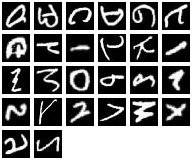

In [1]:
from IPython import display
display.Image("https://i.stack.imgur.com/51MkY.jpg")

First with the dense neural net. Of course as always we first import packages. Models and layers from kkeras are (almost) always there if we are working on keras basis. Matplotlib also almost always necessary. 

In [2]:
from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt

Using TensorFlow backend.


All packages are self-evident except for to_categorical from Keras.utils. It takes a vector of integers and converts into positional matrix of classes. Here is the example:

In [ ]:
a = to_categorical([0, 1, 2, 3], num_classes=4)
print(a)

We first load and display data. Here we are initializing the plot using figure methods, and then create subplots inside using subplot method. Its arguments are number of subplost in terms of columns, number of rows. So the picture here contains 3 sublots vertically and horisontally, using i index. Each subplot will take the index position on a grid with 3 rows and 3 columns. Index starts at 1 in the upper left corner and increases to the right. Method tight_layout automatically adjusts subplot padding between and around images so that the subplot(s) fits into the figure area. I didn't define the area so it is default: figure dimension (width, height) in inches is (6.4, 4.8). Methods xticks, yticks without argument give current position, with arguments set position. 

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(train_images[i], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

Plt.clf method is a clear function that clears plot - we do not need it anymore. Now what is the shape, type and type of labels of our data?

In [ ]:
plt.clf()
print(train_images.shape)
print(train_images.dtype)
print(train_labels.dtype)

so it is 3D tensor of 60000 images each being 28× 28 pixels of unsigned 8 bit integers. And labels are also unsigned integers. Thus mnist.load_data() supplies data with structure (60000, 28, 28) i.e. with 2 dimensions per example representing a greyscale image 28x28. FNN does not adapt to images – it sees it as unstructured data- matrix of unrelated sample vectors for which it would expect separate lables. But we don't want it- this is one sample, so, we flatten (reshape) it into 1 dimensional vectors that have labels. This is the best we can do with feedforward network. We then select first 10000 images for validation and the remaining 500000 for tarining. We later will also use the test images for testing. Of course for classification we convert labels to categorical -so that they will be vectors to which softmax can compare probabilities when computing loss.

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))
partial_train_images = train_images[10000:]
train_images_val = train_images[:10000]
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
train_labels_val = train_labels[:10000]
partial_train_labels=train_labels[10000:]

## Using Shallow FF Network

### Prepare Data
We first convert unsigned 8 bit integers to float 32: normally we use 32-bit precision when training dense neural network on unrelated vectors: dense FF 'expects' real input for subsequent regression or classiication, so at one point or another the training data will have to be converted to 32 bit floats. Since the dataset fits easily in RAM, we might as well convert to float immediately. Why do we divide by 255? the input feature's type before the conversion to float32 is byte (unsigned integer 8). Maximum value of the byte is 255, so division by 255 ensures that the input features are normalized, i. e.  scaled between 0.0 and 1.0 which is natural float representation for grayscale figures.

In [ ]:
partial_train_images=partial_train_images.astype('float32')/255
train_images_val = train_images_val.astype('float32')/255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

Now we can create FF dense network as usual. Input shape is a vector (flattened $28\times 28$ pixels). We do shallow network with 512 neurons because it doesn't make sense to try to discover features - we already killed them by flatening. So many layers won't help but just make it to dsciover non-existing relations. Now we can create FF dense network as usual. Input shape is a vector (flattened $28\times 28$ pixels). Do we need shallow network or deep network?

Very wide, shallow networks are very good at memorization, but not so good at generalization - they overfit because of many parameters they use. So, if we train the network with every possible input value, a super wide network could eventually memorize the corresponding output value that you want. But that's not always useful because for many practical application you won't have every possible input value to train with.

The advantage of multiple layers is that they can learn features at various levels of abstraction. If we tarin network to classify data, we find that the first layer will train itself to recognize very basic features, the next layer train itself to recognize collections features, the next layer train itself to recognize aggregations of feature collections, and the next layer learns even higher-order 'shapes'. Multiple layers are much better at generalizing because they learn all the intermediate features between the raw data and the high-level classification.

In our case we use shallow relatively wide network with 512 neurons because it doesn't make sense to try to discover features - we already killed them by flatening. So many layers won't help but just make it to dsciover non-existing relations. But our data set is very extensive we basically cover almost all possible variations of writing, hense wide network. You could experiment with even wider netwroks to see if it improves performance.

    -Classifier layer is softmax with 10 outputs (classes); 
    -Gradient descent algorithm modification is rmsprop (always a safe choice, but may not be fastest – will discuss may lectures later)
    - Loss is categorical crossentropy - as we have moore than 2 classes
    - Metric that we’ll be watching during training is accuracy  

In [ ]:
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))
network.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

We are ready to fit the model. Training arguments are input data, number of epochs, size of batch, i.e. it will be stochastic (randomly chosen) mini-batch of 228 images and validation data. It returns object with the same data fields as arguments plus sub-object history (history.history) where all the training data is recorded 

In [ ]:
history=network.fit(partial_train_images,
                    partial_train_labels, epochs=5, batch_size=128,
                    validation_data=(train_images_val, train_labels_val))

History objects contains objects standard objects of loss: history.history.val_loss which contains loss on validation set at every epoch of training and history.hstory.loss which contains loss on training set at every epoch. Whatever parameters we are watching values on training and validation set will also be there. This time it is accuracy. The actual training results of this model are.

In [ ]:
history_dict = history.history
print(history_dict.keys())

We can now plot results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# r is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

In [ ]:
#b for blue, o for dots 
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# r is for "solid blue line"
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

Finally lets see how the network performs on test data using evaluate method.

In [ ]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

Not bad. But can we do better by using more specialized network thta is designed for images.

## Using Convolutional Network
As seen above mnist.load_data() supplies the MNIST digits with structure (60000, 28, 28) i.e. with 2 dimensions per example representing a greyscale image 28x28. CNNs layers are adept in interpreting matrix data as we could see in theory. So this time we prepare data for convolutional layers that take 4 dimensional tensors with axes

### Data preapration 
Convert MNIST data to 4-d tensors with axises:
<ul>
    <li>number of samples</li>
    <li>Horizontal pixels dimension</li>
    <li>Vertical pixels dimension</li>
    <li>Number of color channel</li> 
</ul>
So we reshape data and then separate training, validation and test data. We again convert dtype from byte to reals because convolution works with real numbers! We normalize the real numbers bbecause we want to work with the same range of data 

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images_val = train_images[:10000]
partial_train_images = train_images[10000:]
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
train_labels_val = train_labels[:10000]
partial_train_labels=train_labels[10000:]
train_images_val = train_images_val.astype('float32')/255
partial_train_images=partial_train_images.astype('float32')/255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [4]:
print(partial_train_images.shape)
print(partial_train_labels.shape)

(50000, 28, 28, 1)
(50000, 10)


We now create Convolutional NN (CNN) model.It’s a stack of Conv2D and MaxPooling2D layers – 2 pairs that end with convolutional layer. Each layer has activation ReLU. The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions shrink with application of filters. The number of channels (filters in the layer) is controlled by the first argument passed to the Conv2D layers (32 or 64,...) which gives you the idea of the number of trainable parameters: for each filter there is filter size\times filter size trainable weights, further multiplead by the numbe rof channels give you the number of trainable weights in the network.

So what are all the other parameters of the calls (and layers) here?
<ul>
    <li>In convolutional layer second argument specifies the filter size that is in use,</li>
    <li> the third argument specifies the shape of the input</li>
    <li> there are more argument that we do not set here, so they are set to default here:
    <ul>
        <li> we could initilize filter (kernel) weights matrix</li>
        <li>we could initialize bias</li>
        <li>we could 'sample' the output of a layer before feeding it further - this is called stride (later).</li>
        <li> we could specify padding</li>
    </ul>
    </li>
    <li>In MaxPooling2D layer area the argument is the size of the pool (square) from which max value (max-pooling!) is pooled out. The width and height dimensions shrink with application of pooling</li> 
    <li>The output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels)</li>
<ul>
Main mistery is why 32 kernels and how they are/should be initialized. Here are these and other defaults: 
<ul>
    <li>channels’ are number of different krnels (filters) applied to the picture, e.g. 32 means 32 different filters are run over the picture. It depends on expected numbers of features you expect to aggregate. Typical sized are 32 to 512 with the step of 32. If the picture doesn't have too many features (as in our case) you would expect to have narrow channel layers.</li>
    <li>In Conv2D we can specify how to initialize filters but if you do not specify initialization, then they are initialized uniformly at random</li>
    <li>Bias is by defauls initialized to 0</li>
    <li>Padding can be specified  as "valid" or "same"; "valid" means no padding, "same" results in padding with zeros evenly to the left/right or up/down of the input. Default is the "same". 
     <li>Stride is the step of the kernel application. It is a tuple of 2 integers, specifying the step of the convolution filter application along the height and width. Default is 1. When padding="same" and strides=1, the output has the same size as the input.</li>
</ul>


In [5]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))

The last layer of the netwrok is the deicison layer (softmax) that takes a vector as input so even if we feed the softmax directly from convolutional layer we would reshape (flatten) the input. Yet we don't do that right away. Instead after CNN layers we feed results into dense layers. Why insert dense layer between flattening and decision layer? The answer is because we want to couple information that exists from different channels. The dense Layer uses a ReLU activation meaning, that every pre-activation is a linear combination of EVERY output of neurons of a previous convolutional layer. That is, we "force" dense layer to aggregate features discovered by kernels convolutional layers by combining their outputs and we let the dense NN to learn the relation of kernel outputs netween them. As a result, there appear $n\times m \times k$ connections (or weights) where $k$ denotes the number of filters in last convolutional layer and $m\times n$ dimension of a matrix of last convolutional layer denotes to each of the 'dense' neurons that aggregate features obtained from different kernels of last convolutional layer in different ways. In other words, if the preceding convolutional layer outputs a $m\times n$ matrix for each of $k$ channels then the vector of size $m\times n \times k$ is weighted by dense layer, essentially doing multiple linear regressions on its inputs to predict final values of features used for classification. All neurons in dense layer are needed because they are are initialized differently which means that they catch different features fed from convolutional layer. 

The last layer is classification with sotmax that has 10 classes and dense input (all 64 previous neurons are connected to softmax. 

In [6]:
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10, activation='softmax'))
print(cnn.summary())
cnn.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

As we see with each layer area of coverage of each channel is aggregated, so true window grows to  last convolutional layer output the result of convolutions on a picture split into 9 ($3\times 3$) regions. Thus the first conv layer learns very small features, second learns somewhat aggregated features and last learn the biggest combination. The number of parameters though gwos exponentially fast with adding layers! 

Now train:

In [7]:
history=cnn.fit(partial_train_images,
                    partial_train_labels, epochs=5, batch_size=64,
                    validation_data=(train_images_val, train_labels_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 23s 460us/step - loss: 0.1985 - accuracy: 0.9371 - val_loss: 0.0887 - val_accuracy: 0.9757
Epoch 2/5
50000/50000 [==============================] - 24s 472us/step - loss: 0.0508 - accuracy: 0.9844 - val_loss: 0.0494 - val_accuracy: 0.9849
Epoch 3/5
50000/50000 [==============================] - 23s 459us/step - loss: 0.0348 - accuracy: 0.9887 - val_loss: 0.0435 - val_accuracy: 0.9883
Epoch 4/5
50000/50000 [==============================] - 22s 439us/step - loss: 0.0259 - accuracy: 0.9920 - val_loss: 0.0456 - val_accuracy: 0.9871
Epoch 5/5
50000/50000 [==============================] - 23s 465us/step - loss: 0.0211 - accuracy: 0.9935 - val_loss: 0.0520 - val_accuracy: 0.9881


And plot:

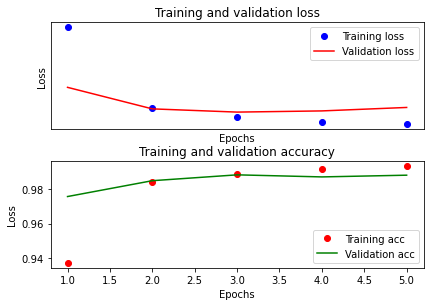

<Figure size 432x288 with 0 Axes>

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
#plt.figure(1)
fig,axis = plt.subplots(nrows=2, ncols=1)
fig.tight_layout()
plt.subplot(211)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.subplot(212)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

Finally check testing accuracy

In [ ]:
test_loss, test_acc = cnn.evaluate(test_images, test_labels)
print('test_acc:', test_acc)